# Import Library

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Nhóm 1/2 Bài tập trên lớp/Thực hành Final/Data processed/final_dataset_improved.csv'

df = pd.read_csv(path)
df.head()

,id,name,num_users,total_cmt,positive,negative,neutral,average_completion_rate,number of resources,rank_binned,course_classification
0,C_655852,series of courses-completed courses without re...,48,0.0,0.0,0.0,0.0,0.648872,162,9.000000,Dissatisfied
1,C_655850,series of classes - class has not started yet,47,0.0,0.0,0.0,0.0,0.648872,91,1.000000,Neutral
2,C_654554,series of courses - now starting,47,0.0,0.0,0.0,0.0,0.648872,99,4.481596,Dissatisfied
3,C_654506,series of courses - the course has ended and t...,47,0.0,0.0,0.0,0.0,0.648872,3,4.481596,Dissatisfied
4,C_629558,medical immunology and pathogen biology,48,0.0,0.0,0.0,0.0,0.648872,91,4.481596,Dissatisfied


In [ ]:
df['course_classification'].value_counts()

,count
course_classification,
Dissatisfied,876
Neutral,585
Satisfied,526
Very dissatisfied,461
Very satisfied,374


In [ ]:
df['course_classification'] = df['course_classification'].map({'Very dissatisfied': 0, 'Dissatisfied': 1, 'Neutral': 2, 'Satisfied': 3, 'Very satisfied': 4})
df.head()

,id,name,num_users,total_cmt,positive,negative,neutral,average_completion_rate,number of resources,rank_binned,course_classification
0,C_655852,series of courses-completed courses without re...,48,0.0,0.0,0.0,0.0,0.648872,162,9.000000,1
1,C_655850,series of classes - class has not started yet,47,0.0,0.0,0.0,0.0,0.648872,91,1.000000,2
2,C_654554,series of courses - now starting,47,0.0,0.0,0.0,0.0,0.648872,99,4.481596,1
3,C_654506,series of courses - the course has ended and t...,47,0.0,0.0,0.0,0.0,0.648872,3,4.481596,1
4,C_629558,medical immunology and pathogen biology,48,0.0,0.0,0.0,0.0,0.648872,91,4.481596,1


In [ ]:
df['course_classification'].value_counts().sort_index()

,count
course_classification,
0,461
1,876
2,585
3,526
4,374


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2822 non-null   object 
 1   name                     2822 non-null   object 
 2   num_users                2822 non-null   int64  
 3   total_cmt                2822 non-null   float64
 4   positive                 2822 non-null   float64
 5   negative                 2822 non-null   float64
 6   neutral                  2822 non-null   float64
 7   average_completion_rate  2822 non-null   float64
 8   number of resources      2822 non-null   int64  
 9   rank_binned              2822 non-null   float64
 10  course_classification    2822 non-null   int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 242.6+ KB


# Data Preparation

In [ ]:
X = df.drop(columns=['id',
                     'name',
                     'course_classification',])
y = df['course_classification']

X.shape

(2822, 8)

Bộ dữ liệu được chia thành 3 tập là train, validation, test theo tỷ lệ 8:1:1

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
X_train.shape, X_test.shape, X_valid.shape

((2257, 8), (282, 8), (283, 8))

In [ ]:
scaler = PowerTransformer()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
# Các hàm xác định và in độ đo đánh giá

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix for {model}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def print_acc(model_name, acc, prec, rec, f1):
    print(f'{model_name}\n - Accuracy: {acc},\n - Precision: {prec},\n - Recall: {rec},\n - F1 Score: {f1}\n')

# Ensemble Model

In [ ]:
# Model Class to be used for different ML algorithms
class ClassifierModel(object):
    def __init__(self, clf, params=None):
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def fit(self,x,y):
        return self.clf.fit(x,y)

    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_

    def predict(self, x):
        return self.clf.predict(x)

In [ ]:
def trainModel(model, x_train, y_train, x_test, n_folds, seed):
    cv = KFold(n_splits= n_folds, shuffle=True, random_state=seed)
    scores = cross_val_score(model.clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    y_pred = cross_val_predict(model.clf, x_train, y_train, cv=cv, n_jobs=-1)
    return scores, y_pred

## Random Forest Classifier

In [ ]:
# Random Forest parameters
rf_params = {
    'n_estimators': 200,
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'criterion': 'entropy',
}
rfc_model = ClassifierModel(clf=RandomForestClassifier, params=rf_params)
rfc_scores, rfc_train_pred = trainModel(rfc_model, X_train, y_train, X_test, 5, 0)
rfc_scores

array([0.83849558, 0.79646018, 0.7827051 , 0.827051  , 0.79600887])

In [ ]:
# Getting features importance
rfc_features = rfc_model.feature_importances(X_train, y_train)
rfc_features

array([0.10767269, 0.10730894, 0.16025478, 0.15602157, 0.08189958,
       0.13563188, 0.11532266, 0.13588791])

## Decision Tree

In [ ]:
# Decision Tree parameters
dt_params = {
    'max_depth': 15,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'criterion': 'entropy',
    'splitter': 'best'
}

# Instantiate the Decision Tree model with the specified parameters
dt_model = ClassifierModel(clf=DecisionTreeClassifier, params=dt_params)

# Train the Decision Tree model and get scores
dt_scores, dt_train_pred = trainModel(dt_model, X_train, y_train, X_test, 5, 0)

# Display the Decision Tree scores
dt_scores

array([0.8340708 , 0.81637168, 0.77605322, 0.83148559, 0.80931264])

In [ ]:
# Getting features importance
dt_features = dt_model.feature_importances(X_train, y_train)
dt_features

array([0.0728865 , 0.01536753, 0.17603488, 0.2848119 , 0.01419407,
       0.1869371 , 0.10073073, 0.14903728])

## SVM

In [ ]:
# SVM parameters
svm_params = {
    'kernel': 'rbf',  # Linear kernel for SVM
    'C': 100,  # Regularization parameter
    'gamma': 'scale',
}
# Instantiate the SVM model with the specified parameters
svm_model = ClassifierModel(clf=SVC, params=svm_params)

# Train the SVM model and get scores
svm_scores, svm_train_pred = trainModel(svm_model, X_train, y_train, X_test, 5, 0)

svm_scores

array([0.91150442, 0.88495575, 0.87804878, 0.87361419, 0.89135255])

In [ ]:
# Fit the SVM model
svm_model.clf.fit(X_train, y_train)

# Calculate permutation importance
result = permutation_importance(svm_model.clf, X_train, y_train, n_repeats=10, random_state=42)

# Get the mean importance of each feature
svm_features = result.importances_mean

# Display the feature importances
print(svm_features)

[0.19986708 0.1946389  0.41160833 0.48613203 0.1684537  0.2570669
 0.16220647 0.25564909]


## KNN

In [ ]:
# KNN parameters
knn_params = {
    'n_neighbors': 5,  # Number of neighbors to use
    'weights': 'distance',  # Use uniform weights for neighbors
    'algorithm': 'auto',  # Algorithm for computing the nearest neighbors
    'metric': 'minkowski',  # Distance metric to use
    'p': 2  # Power parameter for Minkowski distance
}

# Instantiate the KNN model with the specified parameters
knn_model = ClassifierModel(clf=KNeighborsClassifier, params=knn_params)

# Train the KNN model and get scores
knn_scores, knn_train_pred = trainModel(knn_model, X_train, y_train, X_test, 5, 0)

# Display the KNN scores
knn_scores


array([0.74336283, 0.74336283, 0.70953437, 0.70066519, 0.75609756])

In [ ]:
# Fit the KNN model to the training data
knn_model.clf.fit(X_train, y_train)

# Calculate permutation importance
result = permutation_importance(knn_model.clf, X_train, y_train, n_repeats=10, random_state=42)

# Get the mean importance of each feature
knn_features = result.importances_mean

# Display the feature importances
print(knn_features)


[0.24590164 0.1731502  0.3355782  0.37576429 0.17465662 0.26428888
 0.25157288 0.31125388]


## LightGBM

In [ ]:
from lightgbm import LGBMClassifier

# LightGBM parameters
lgbm_params = {
    'n_estimators': 100,
    'max_depth': 20,
    'min_child_samples': 40,
    'min_split_gain': 0.01,
    'colsample_bytree': 1.0,
    'subsample': 0.8,
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'verbose': -1,
    'objective': 'multiclass',  # Sửa thành 'multiclass' cho phân loại nhiều lớp
    'num_class': len(set(y_train)),  # Số lượng lớp trong dữ liệu,
}

# Instantiate the LightGBM model
lgbm_model = ClassifierModel(clf=LGBMClassifier, params=lgbm_params)

# Train and evaluate the LightGBM model
lgbm_scores, lgbm_train_pred = trainModel(lgbm_model, X_train, y_train, X_test, 5, 0)

lgbm_scores

array([0.89159292, 0.82522124, 0.83813747, 0.84922395, 0.827051  ])

In [ ]:
# Getting features importance
lgbm_features = lgbm_model.feature_importances(X_train, y_train)
lgbm_features

array([2195, 1105, 2761, 2292,  897, 1690, 2335, 1070], dtype=int32)

In [ ]:
# Giả sử bạn đã có danh sách tên các cột (tên đặc trưng)
feature_names = ['num_users', 'total_cmt', 'positive', 'negative', 'neutral', 'average_completion_rate', 'number of resources', 'rank_binned ']

# Chuyển X_train (nếu là NumPy array) thành DataFrame với tên các cột
X_train_df = pd.DataFrame(X_train, columns=feature_names)

# Create a dataframe with features
feature_dataframe = pd.DataFrame({
    'Random Forest feature importances': rfc_features,
    'Decision Tree  feature importances': dt_features,
    'SVM feature importances': svm_features,
    'KNN feature importances': knn_features,
    'LightGBM feature importances': lgbm_features,
    })

In [ ]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe

,Random Forest feature importances,Decision Tree feature importances,SVM feature importances,KNN feature importances,LightGBM feature importances,mean
0,0.107673,0.072887,0.199867,0.245902,2195,439.125266
1,0.107309,0.015368,0.194639,0.173150,1105,221.098093
2,0.160255,0.176035,0.411608,0.335578,2761,552.416695
3,0.156022,0.284812,0.486132,0.375764,2292,458.660546
4,0.081900,0.014194,0.168454,0.174657,897,179.487841
5,0.135632,0.186937,0.257067,0.264289,1690,338.168785
6,0.115323,0.100731,0.162206,0.251573,2335,467.125967
7,0.135888,0.149037,0.255649,0.311254,1070,214.170366


In [ ]:
acc_pred_train = pd.DataFrame ({'RandomForest': rfc_scores.ravel(),
                                'DecisionTree': dt_scores.ravel(),
                                'SVM': svm_scores.ravel(),
                                'KNN': knn_scores.ravel(),
                                'LightGBM': lgbm_scores.ravel()
                              })
acc_pred_train.head()

,RandomForest,DecisionTree,SVM,KNN,LightGBM
0,0.838496,0.834071,0.911504,0.743363,0.891593
1,0.796460,0.816372,0.884956,0.743363,0.825221
2,0.782705,0.776053,0.878049,0.709534,0.838137
3,0.827051,0.831486,0.873614,0.700665,0.849224
4,0.796009,0.809313,0.891353,0.756098,0.827051


<Axes: title={'center': 'Pearson correlation of features'}>

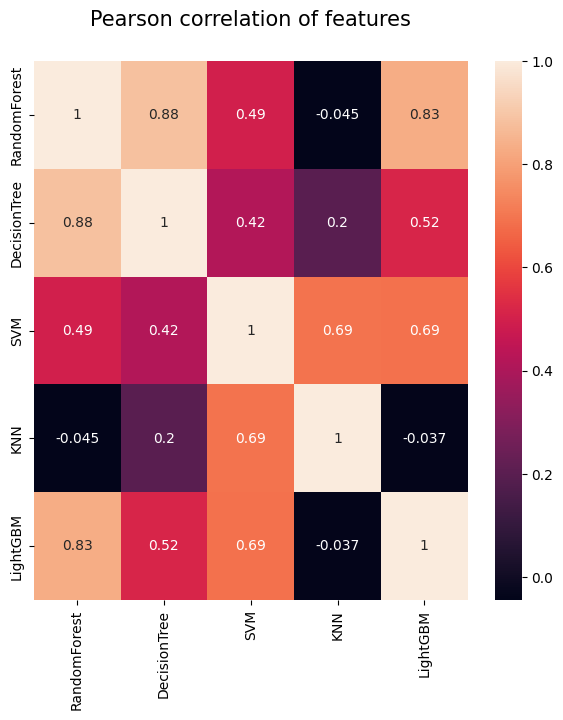

In [ ]:
import seaborn as sns

colormap = plt.cm.RdBu
plt.figure(figsize=(7,7))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(acc_pred_train.astype(float).corr(), annot=True)

In [ ]:
X_train = np.column_stack(( svm_train_pred, rfc_train_pred, dt_train_pred, knn_train_pred, lgbm_train_pred))

In [ ]:
X_train.shape

(2257, 5)

In [ ]:
acc_pred_train

,RandomForest,DecisionTree,SVM,KNN,LightGBM
0,0.838496,0.834071,0.911504,0.743363,0.891593
1,0.796460,0.816372,0.884956,0.743363,0.825221
2,0.782705,0.776053,0.878049,0.709534,0.838137
3,0.827051,0.831486,0.873614,0.700665,0.849224
4,0.796009,0.809313,0.891353,0.756098,0.827051


## Stacking Model

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, cross_val_score

def trainStackModel(x_train, y_train, x_test, n_folds, seed):
    # Khởi tạo K-fold cross-validation
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    # Khởi tạo mô hình CatBoostClassifier
    gbm = CatBoostClassifier(
        iterations=300,           # Số vòng lặp huấn luyện
        depth=8,                   # Độ sâu cây quyết định
        learning_rate=0.1,        # Tốc độ học
        l2_leaf_reg=3,             # Regularization
        random_seed=seed,          # Seed để đảm bảo lặp lại
        verbose=0,                 # Tắt hiển thị thông tin huấn luyện
        task_type='CPU',           # Sử dụng CPU để huấn luyện (hoặc 'GPU' nếu có GPU)
        loss_function='MultiClass' # Hàm mất mát cho bài toán phân loại đa lớp
    ).fit(x_train, y_train)

    # Đánh giá hiệu suất bằng Cross-Validation
    scores = cross_val_score(gbm, x_train, y_train, scoring='accuracy', cv=cv)

    return scores

In [ ]:
stackModel_scores = trainStackModel(X_train, y_train, X_test, 5, 0)

In [ ]:
acc_pred_train['EnsembleModel'] = stackModel_scores
acc_pred_train

,RandomForest,DecisionTree,SVM,KNN,LightGBM,EnsembleModel
0,0.838496,0.834071,0.911504,0.743363,0.891593,0.913717
1,0.796460,0.816372,0.884956,0.743363,0.825221,0.889381
2,0.782705,0.776053,0.878049,0.709534,0.838137,0.869180
3,0.827051,0.831486,0.873614,0.700665,0.849224,0.873614
4,0.796009,0.809313,0.891353,0.756098,0.827051,0.906874


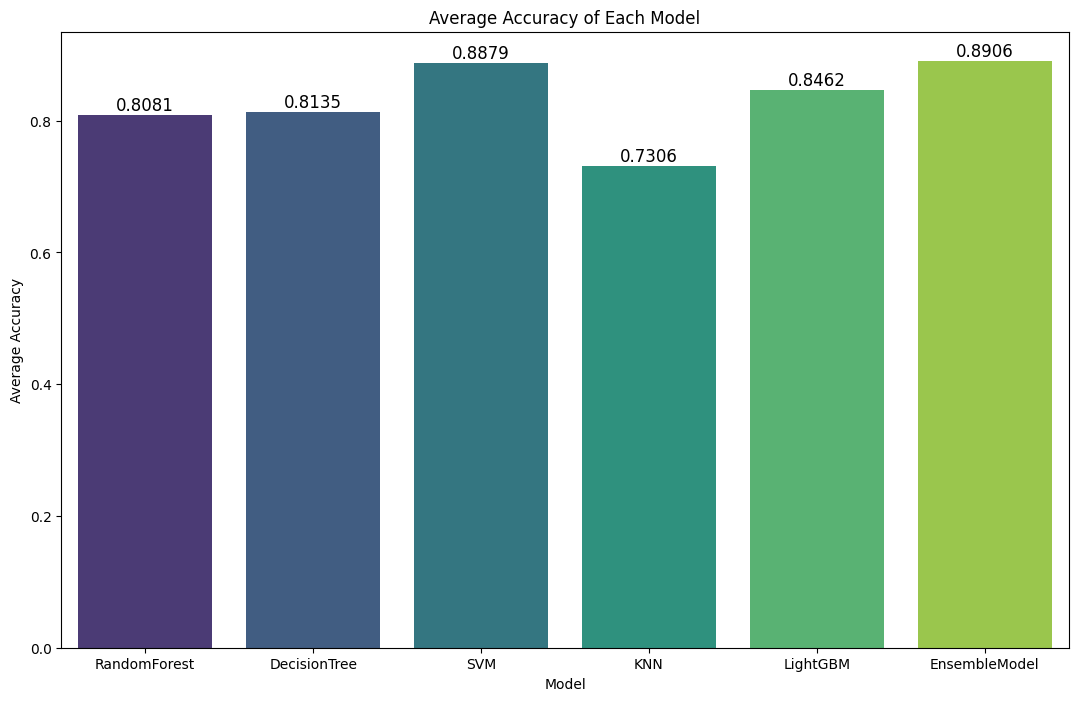

In [ ]:
accuracy_mean = acc_pred_train.mean()
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=accuracy_mean.index, y=accuracy_mean.values, palette="viridis")

plt.title("Average Accuracy of Each Model")
plt.xlabel("Model")
plt.ylabel("Average Accuracy")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black',
                xytext=(0, 7), textcoords='offset points')

plt.show()